In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_fireworks langgraph wikipedia duckduckgo-search tavily-python

In [2]:
import getpass
import os


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model="gpt-4o-mini")
# Uncomment for a Fireworks model
# fast_llm = ChatFireworks(model="accounts/fireworks/models/firefunction-v1", max_tokens=32_000)
long_context_llm = ChatOpenAI(model="gpt-4o")
longer_context_llm = ChatOpenAI(model="gpt-4")

In [4]:
from typing import List, Optional

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Business compitior analyst writer. Write an outline for an article about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

In [5]:
example_topic = "Compititors of quixy"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Competitors of Quixy

## Introduction

An overview of Quixy as a low-code platform, its target market, and its primary features.

## Market Overview

Insight into the low-code development market, its growth, and the demand for platforms like Quixy.

## Key Competitors

A detailed analysis of the main competitors of Quixy in the low-code space.

### OutSystems

Overview of OutSystems, its features, strengths, and weaknesses.

### Mendix

Overview of Mendix, its features, strengths, and weaknesses.

### Appian

Overview of Appian, its features, strengths, and weaknesses.

### Microsoft Power Apps

Overview of Microsoft Power Apps, its features, strengths, and weaknesses.

### Zoho Creator

Overview of Zoho Creator, its features, strengths, and weaknesses.

### Bubble

Overview of Bubble, its features, strengths, and weaknesses.

### Salesforce Lightning Platform

Overview of Salesforce Lightning Platform, its features, strengths, and weaknesses.

## Comparison of Features

A side-by-si

In [6]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below.
    Please identify and recommend some blogs or articles on closely related subjects.
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the
    typical content and structure included in those articels for similar topics.

Please list subjects which focus on market research analysis questions, around products and pricing and all general things around it.

Topic of interest: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [7]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Competitors of Quixy', 'Market research analysis', 'Product pricing strategies', 'Competitive analysis in software', 'Business intelligence', 'SaaS market trends', 'Product differentiation', 'Market share analysis', 'Customer needs assessment', 'Pricing models in software', 'Market segmentation', 'SWOT analysis of competitors', 'Industry benchmarks', 'Consumer behavior analysis'])

In [8]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of article column editors who will work together to create a comprehensive article
            on the topic. Each of them represents a different perspective in market analysis, role, or affiliation related to this topic.
            You can use other Wikipedia pages, blogs, articles of related topics for inspiration.
            For each editor, add a description of what they will focus on.

    article outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Perspectives)

In [9]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [10]:
perspectives = await survey_subjects.ainvoke(example_topic)

/opt/anaconda3/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/anaconda3/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [11]:
perspectives.dict()

/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_2705/3220195933.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  perspectives.dict()


{'editors': [{'affiliation': 'Market analysis',
   'name': 'AliceSmith',
   'role': 'Market Analyst',
   'description': 'Alice will focus on analyzing the market trends and competitors of Quixy, looking at their strengths, weaknesses, opportunities, and threats in comparison to Quixy.'},
  {'affiliation': 'Pricing strategies',
   'name': 'JohnDoe',
   'role': 'Pricing Strategist',
   'description': "John will concentrate on evaluating the pricing strategies of Quixy's competitors and how they impact the market positioning and competitiveness of Quixy."},
  {'affiliation': 'Positioning (marketing)',
   'name': 'EmilyJones',
   'role': 'Marketing Specialist',
   'description': 'Emily will explore how the competitors of Quixy position themselves in the market and how Quixy can differentiate its brand to stand out among competitors.'},
  {'affiliation': 'Business intelligence',
   'name': 'DavidBrown',
   'role': 'BI Analyst',
   'description': "David will analyze the business intelligence

In [12]:
from typing import Annotated

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

In [13]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced article writer and want to edit a specific page for market analysis. \
Besides your identity as an article writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [14]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, I'm specifically focusing on the market trends and competitors of Quixy. To gain a deeper understanding, could you share which competitors you believe are the most significant in this space and what their primary strengths are?"

In [15]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-4o"
).with_structured_output(Queries, include_raw=True)

In [16]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['Quixy competitors',
 'Quixy market trends',
 'Quixy competitors strengths',
 'Comparison of low-code platforms with Quixy']

In [17]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with an article writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [18]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

'''
# Tavily is typically a better search engine, but your free queries are limited
search_engine = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]
'''

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [19]:
import json

from langchain_core.runnables import RunnableConfig


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].tool_calls[0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [20]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

AttributeError: 'NoneType' object has no attribute 'cited_urls'

In [ ]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(
    run_name="Conduct Interviews"
)

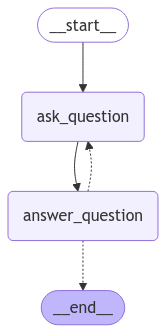

In [ ]:
from IPython.display import Image, display

try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
final_step = step

/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content="Yes, that's correct! My focus is on analyzing market trends, competitors' strategies, and market segmentation related to Quixy's competitors. Can you provide insights on the key competitors in the market and their unique selling propositions?", additional_kwargs={'refusal': None}


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content='Quixy, a leading no-code platform, faces competition from several key players in the market, each with unique selling propositions (USPs) that cater to diverse business needs. Notable competitors include Airtable, Newgen, and Odoo Studio.  \n\n1. **Airtable** - Airtable combines 


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='What market segments are currently driving demand for no-code platforms like Quixy, and how do these segments differ in their needs and expectations from such tools?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens'


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content="The demand for no-code platforms like Quixy is being driven by several market segments, each with distinct needs and expectations. Key segments include small to medium-sized enterprises (SMEs), large enterprises, and various industry verticals such as healthcare, finance, educati


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='What strategies are Quixy and its competitors employing to differentiate themselves in this growing market and attract their target segments?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1576, 'total_tokens': 


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content="Quixy and its competitors are employing various strategies to differentiate themselves in the growing no-code platform market and attract their target segments. Here are some notable approaches:  \n\n1. **User Empowerment**: Quixy focuses on empowering non-technical users by prov


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='What are the emerging trends in the no-code market that could potentially influence the competitive landscape among Quixy and its competitors in the near future?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 23


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content='Several emerging trends in the no-code market are poised to influence the competitive landscape among Quixy and its competitors in the near future:\n\n1. **AI and Machine Learning Integration**: The integration of artificial intelligence (AI) and machine learning (ML) into no-cod


In [ ]:
final_state = next(iter(final_step.values()))

In [ ]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Business compitior analyst writer. You have gathered information from experts and search engines.
            Now, you are refining the outline of the Wikipedia page. \
            You need to make sure that the outline is comprehensive and specific. \
            Topic you are writing about: {topic}

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [ ]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [ ]:
print(refined_outline.as_str)

# Competitors of Quixy

## Introduction

An overview of Quixy and its role in the no-code application development market.

## Understanding Quixy

A brief description of Quixy's features, strengths, and target audience.

## Key Competitors

A detailed analysis of the main competitors of Quixy in the no-code platform space.

### AppGyver

Overview of AppGyver, its key features, target market, and how it compares to Quixy.

### Bubble

An examination of Bubble's offerings, strengths, and weaknesses in relation to Quixy.

### OutSystems

Analysis of OutSystems as a low-code platform, its features, and positioning against Quixy.

### Mendix

Description of Mendix's capabilities, use cases, and competitive edge over Quixy.

### Airtable

Exploration of Airtable's functionalities and its competition with Quixy.

### Zoho Creator

Insight into Zoho Creator's features and market positioning relative to Quixy.

### Microsoft Power Apps

Evaluation of Microsoft Power Apps as a competitor, includ

In [ ]:
final_state['references']

{'https://www.bp-3.com/blog/10-low-code/no-code-trends-for-2024': '10 Low-Code/No-Code Trends for the Upcoming Year . Synopsis. Market Growth: The low-code/no-code market is projected to reach $86.9 billion by 2027, driven by demand for quick app delivery and digital transformation.; Widespread Adoption: By 2025, low-code tools are expected to account for over 70% of software development, enabling non-technical users to contribute to app creation.',
 'https://www.startechup.com/blog/8-low-code-no-code-trends-in-2024/': "Whether you're a developer or a business owner, you've probably heard the buzz around low-code/no-code platforms. As we leap into 2024, get ready for these platforms to shake up the software development game like never before.. These platforms address the global shortage of high-code developers, while no-code bridges the gap by making it easier for non-technical users to get started.",
 'https://bubble.io/blog/state-of-no-code-development/': "This approach of combining 

In [ ]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = InMemoryVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=3)

In [ ]:
retriever.invoke("enhancing API capabilities")

[Document(id='51c44e20-dfbb-4db8-a069-3c9129596dcd', metadata={'source': 'https://www.cdotrends.com/story/4364/unlocking-future-low-codeno-code-trends-and-predictions'}, page_content="Emerging trends. Natural Language-Driven Interactions: ... Low-code/no-code platforms, bolstered by AI and GenAI, are revolutionizing how businesses approach application development. By empowering citizen developers and accelerating innovation, these platforms are addressing today's challenges and shaping the future of technology adoption ..."),
 Document(id='8e758a34-7e4c-4d72-bc24-0ad9b4f51f69', metadata={'source': 'https://bubble.io/blog/state-of-no-code-development/'}, page_content="This approach of combining AI with no-code makes software development even easier and more accessible than no-code alone, while also further reducing the time it takes to complete a project. Accordingly, we've seen a slew of new AI-powered no-code solutions enter the market, like Anakin AI, Druid AI, and Obviously AI. Alle

In [ ]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [ ]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## Understanding Quixy

Quixy is a cloud-based no-code platform designed to empower businesses and individuals to build custom applications without the need for traditional coding expertise. It offers a comprehensive suite of tools that allow users to automate workflows, design rich user interfaces, and manage data effectively. Quixy is particularly well-suited for organizations looking to streamline operations and increase efficiency by enabling non-technical staff to create applications tailored to specific business needs. 

One of Quixy’s standout features is its intuitive drag-and-drop interface, which simplifies the development process and makes it accessible to users with varying levels of technical proficiency. This feature is complemented by a wide array of pre-built templates and integrations, which help users to quickly deploy applications while also ensuring compatibility with existing systems. Additionally, Quixy provides robust security measures and compliance standards, e

In [ ]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]",'
            " avoiding duplicates in the footer. Include URLs in the footer.",
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [ ]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Competitors of Quixy

## Understanding Quixy

Quixy is a cloud-based no-code platform designed to empower businesses and individuals to build custom applications without the need for traditional coding expertise. It offers a comprehensive suite of tools that allow users to automate workflows, design rich user interfaces, and manage data effectively. Quixy is particularly well-suited for organizations looking to streamline operations and increase efficiency by enabling non-technical staff to create applications tailored to specific business needs. 

One of Quixy’s standout features is its intuitive drag-and-drop interface, which simplifies the development process and makes it accessible to users with varying levels of technical proficiency. This feature is complemented by a wide array of pre-built templates and integrations, which help users to quickly deploy applications while also ensuring compatibility with existing systems. Additionally, Quixy provides robust security measures and

In [ ]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [ ]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node, retry=RetryPolicy(max_attempts=3))
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.add_edge(START, nodes[0][0])
builder_of_storm.add_edge(nodes[-1][0], END)
storm = builder_of_storm.compile(checkpointer=MemorySaver())

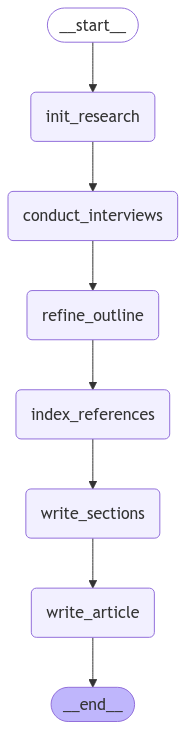

In [ ]:
from IPython.display import Image, display

try:
    display(Image(storm.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "my-thread"}}
async for step in storm.astream(
    {
        "topic": "market analysis for Quixy",
    },
    config,
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])

/opt/anaconda3/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/anaconda3/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


init_research
--  {'topic': 'market analysis for Quixy', 'outline': Outline(page_title='Market Analysis for Quixy', sections=[Section(section_title='Introduction', description='A brief overview of Quixy and its significance in the market.', subsections=None), Section(section_title='Company Overview', description='An 


/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))
/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))
/var/folders/_c/_wx3_r550ylgdgq0h4q8sllw0000gn/T/ipykernel_1740/2208026300.py:35: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10

conduct_interviews
--  {'topic': 'market analysis for Quixy', 'outline': Outline(page_title='Market Analysis for Quixy', sections=[Section(section_title='Introduction', description='A brief overview of Quixy and its significance in the market.', subsections=None), Section(section_title='Company Overview', description='An 
refine_outline
--  {'topic': 'market analysis for Quixy', 'outline': Outline(page_title='Market Analysis for Quixy', sections=[Section(section_title='Introduction', description='A brief overview of Quixy and its significance in the no-code development platform market.', subsections=None), Section(section_title='Compan
index_references
--  {'topic': 'market analysis for Quixy', 'outline': Outline(page_title='Market Analysis for Quixy', sections=[Section(section_title='Introduction', description='A brief overview of Quixy and its significance in the no-code development platform market.', subsections=None), Section(section_title='Compan
write_sections
--  {'topic': 'mark

In [ ]:
checkpoint = storm.get_state(config)
article = checkpoint.values["article"]

In [ ]:
article= '''
# summary

Quixy is a prominent cloud-based no-code platform that allows businesses to automate workflows and create complex applications without the need for coding skills. It is designed to empower non-technical users with its intuitive drag-and-drop interface, making it possible to build applications more quickly and efficiently than traditional coding methods. Quixy has gained notable recognition for its ease of use and customer satisfaction, particularly among project managers who are keen on streamlining workflows and enhancing productivity.[1][2]
The platform adopts a tiered pricing model, catering to a variety of organizational sizes and needs with its Platform, Solution, and Enterprise plans. This pricing structure is crafted to provide scalable solutions that align with the specific requirements of different businesses. Unlike some of its competitors, Quixy does not publicly disclose its pricing on its website, which varies based on several factors including the number of users, additional features, and support options.[3][4]
In the competitive landscape of no-code and low-code development platforms, Quixy is often compared to rivals such as OutSystems, Bubble, and AppSheet. Quixy stands out with its high user satisfaction rating of 99%, surpassing competitors like Bubble, which has a satisfaction rating of 92%. These comparisons highlight the diverse pricing strategies and features offered across platforms, with OutSystems offering plans ranging from free to $1512.50, thus providing flexible options for businesses of varying sizes and requirements.[5][6]
Overall, the choice between Quixy and other no-code or low-code tools often hinges on factors such as the complexity of the applications, the number of users, and the specific features required. Organizations must carefully evaluate these platforms, taking into account user satisfaction ratings and pricing models, to select the tool that best fits their operational needs and budget constraints. This decision-making process is crucial for businesses aiming to leverage no-code solutions for rapid development and deployment while managing costs effectively.[5][7]
---
References:
1. Quixy's Official Website
2. User Reviews and Ratings
3. Company Pricing Page
4. Capterra Pricing Comparison
5. OutSystems Pricing Information
6. Bubble Pricing Information
7. AppSheet Features and Pricing

# Quixy

Quixy is a cloud-based, no-code platform designed to empower business users to automate workflows and create enterprise-grade applications without needing coding skills[1][2]. The platform boasts a user-friendly interface, which allows users to build applications significantly faster than traditional methods through its drag-and-drop design elements[1]. This capability makes Quixy a valuable tool for project managers seeking to streamline workflows, manage tasks, and enhance productivity[3].

## Pricing Structure

Quixy's pricing model is organized into three distinct tiers to cater to various organizational sizes and needs: Platform, Solution, and Enterprise[4]. Each tier provides scalable solutions tailored to the specific requirements of different businesses[4]. While Quixy does not list its pricing details explicitly on its website, the pricing varies based on factors such as the number of users, extra features, type of support, hosting options, and uptime guarantees[5][4].

### Platform Plan

The Platform plan is ideal for situations where the number of applications or workflows is high, offering businesses flexibility in scaling their operations[6].

### Solution Plan

The Solution plan is better suited for organizations with a high number of users but a lower number of apps or workflows. This plan focuses on accommodating user-specific needs while managing fewer applications[6].

### Enterprise Plan

Designed for larger organizations, the Enterprise plan provides access to advanced enterprise features and supports extensive customization and integration options[6]. Companies interested in this plan are encouraged to contact Quixy directly for more detailed information[6].

## User Experience and Feedback

Quixy is highly rated by users for its ease of use, customer support, and value for money, with an overall rating of 4.6 out of 5 from user reviews[7]. Many users have praised its intuitive interface and functionality, although there are some concerns regarding the support team's understanding of the product[7]. Despite this, Quixy remains a popular choice among businesses looking for efficient no-code solutions to streamline their operations[7].

# Competitor Analysis

In the realm of no-code and low-code development platforms, Quixy stands out with its impressive user satisfaction rating of 99%, surpassing competitors like Bubble, which has a satisfaction rating of 92%[8]. Quixy's overall score of 8.7 also positions it favorably against Bubble, which has a score of 7.6[8]. When comparing pricing and features, platforms such as AppSheet and OutSystems present a range of options and considerations. For instance, users can compare these platforms using Capterra, which provides detailed insights on pricing, features, and user reviews[9][10].
The pricing strategies of these platforms are diverse, reflecting their varied offerings and target audiences. OutSystems, for example, offers three pricing plans ranging from free to $1512.50, accommodating different budgetary needs and feature requirements[5][11]. The complexity of applications, number of users, and additional features required can significantly influence the overall cost, making it essential for organizations to choose a plan that aligns with their specific needs[5].
Ultimately, businesses seeking to implement no-code or low-code solutions should carefully evaluate their options by comparing the pricing models and user satisfaction ratings of platforms like Quixy, AppSheet, OutSystems, and Bubble, to ensure they select a tool that best fits their operational requirements and financial constraints.

# Pricing Comparison

When evaluating no-code and low-code tools, understanding the pricing structure is crucial for organizations aiming to find the most cost-effective solution that meets their needs. Quixy offers a tiered pricing model tailored to accommodate businesses of varying sizes and requirements. It includes three distinct plans: Platform, Solution, and Enterprise, which are designed to provide scalable solutions for different business needs[4]. While Quixy does not offer a free trial, it has been recognized for its strong security safeguards and flexibility, providing good value across its pricing plans[3].
OutSystems, another prominent player in the low-code market, also offers a tiered pricing approach. Their pricing plans range from $0 to $1512.50, depending on the features, number of users, and level of support required[11][5]. This allows businesses to start free and scale as they grow, making it a flexible option for organizations with dynamic needs. OutSystems provides multiple runtime environments, including development and production, and offers both cloud and on-premises hosting options[12].
In comparison, Bubble, another low-code platform, has a different pricing strategy. Unlike Quixy, Bubble offers a $25 plan billed yearly, with no free trial available, highlighting a more straightforward pricing approach[13]. When comparing the overall pricing and user satisfaction ratings, Quixy scores higher with a satisfaction rating of 99% compared to Bubble's 92%, emphasizing its favorable reception among users[8].

# Features and Functionality Comparison

When comparing Quixy with other no-code and low-code tools, several key features and functionalities stand out. Quixy offers a variety of unique tools that differentiate it from its competitors, including API integration, case management, invoicing, work order management, quality management, and inventory control[14]. It is designed to integrate seamlessly with existing systems and databases, allowing businesses to utilize their current infrastructure without the need for complex migration processes[15].
In contrast, AppSheet supports integration with a broad array of data sources such as Google Sheets, Excel, SQL databases, and cloud storage services[16]. It is equipped with advanced functionalities like automated workflows, data capture, offline access, and AI-driven features that facilitate more intelligent app development[16]. The AppSheet Editor further allows for extensive customization of the app's user interface, functionalities, and user interaction with data, including features such as data entry forms, maps for location data, and charts for data visualizations[17].
Both platforms operate within a no-code or low-code environment, enabling users to create customized applications tailored to their specific needs without relying on extensive coding[15][18]. This approach is increasingly popular among businesses looking to rapidly develop and deploy applications without the need for a significant investment in development resources[18].

# Factors Influencing Pricing

The pricing of no-code and low-code platforms like Quixy and OutSystems is influenced by a variety of factors, tailored to meet the diverse needs of different organizations. Key elements that impact the pricing include the complexity of applications you wish to build, the number of users, and any additional features that might be required for your specific use case[5][11].
Moreover, the type of support provided can play a significant role in determining the overall cost. Platforms often offer multiple support levels ranging from community support to professional 24x7 assistance, impacting pricing tiers accordingly[12]. Hosting options, such as choosing between cloud hosting or on-premises installation, also add another layer of cost differentiation. OutSystems, for instance, provides flexible hosting choices and uptime guarantees, which can be crucial for businesses with specific reliability and compliance needs[12].
For companies seeking integration capabilities, Quixy offers robust options that allow businesses to leverage their existing systems and databases, avoiding the need for complex migrations, which can be a cost-saving advantage[15]. This integration capability, however, may require additional investment in understanding and mastering the platform, which can influence pricing indirectly[15].
Lastly, subscription models and licensing structures also affect how pricing is structured. OutSystems, for example, is offered as a yearly subscription, with tiered pricing that accommodates various business growth stages, starting from free plans to more comprehensive enterprise-level solutions[11][19]. These factors combined create a pricing landscape that is designed to be flexible, scalable, and adaptive to different organizational requirements and budgets.'''

In [ ]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))


## summary

Quixy is a prominent cloud-based no-code platform that allows businesses to automate workflows and create complex applications without the need for coding skills. It is designed to empower non-technical users with its intuitive drag-and-drop interface, making it possible to build applications more quickly and efficiently than traditional coding methods. Quixy has gained notable recognition for its ease of use and customer satisfaction, particularly among project managers who are keen on streamlining workflows and enhancing productivity.[1][2]
The platform adopts a tiered pricing model, catering to a variety of organizational sizes and needs with its Platform, Solution, and Enterprise plans. This pricing structure is crafted to provide scalable solutions that align with the specific requirements of different businesses. Unlike some of its competitors, Quixy does not publicly disclose its pricing on its website, which varies based on several factors including the number of users, additional features, and support options.[3][4]
In the competitive landscape of no-code and low-code development platforms, Quixy is often compared to rivals such as OutSystems, Bubble, and AppSheet. Quixy stands out with its high user satisfaction rating of 99%, surpassing competitors like Bubble, which has a satisfaction rating of 92%. These comparisons highlight the diverse pricing strategies and features offered across platforms, with OutSystems offering plans ranging from free to $1512.50, thus providing flexible options for businesses of varying sizes and requirements.[5][6]
Overall, the choice between Quixy and other no-code or low-code tools often hinges on factors such as the complexity of the applications, the number of users, and the specific features required. Organizations must carefully evaluate these platforms, taking into account user satisfaction ratings and pricing models, to select the tool that best fits their operational needs and budget constraints. This decision-making process is crucial for businesses aiming to leverage no-code solutions for rapid development and deployment while managing costs effectively.[5][7]
---
References:
1. Quixy's Official Website
2. User Reviews and Ratings
3. Company Pricing Page
4. Capterra Pricing Comparison
5. OutSystems Pricing Information
6. Bubble Pricing Information
7. AppSheet Features and Pricing

## Quixy

Quixy is a cloud-based, no-code platform designed to empower business users to automate workflows and create enterprise-grade applications without needing coding skills[1][2]. The platform boasts a user-friendly interface, which allows users to build applications significantly faster than traditional methods through its drag-and-drop design elements[1]. This capability makes Quixy a valuable tool for project managers seeking to streamline workflows, manage tasks, and enhance productivity[3].

### Pricing Structure

Quixy's pricing model is organized into three distinct tiers to cater to various organizational sizes and needs: Platform, Solution, and Enterprise[4]. Each tier provides scalable solutions tailored to the specific requirements of different businesses[4]. While Quixy does not list its pricing details explicitly on its website, the pricing varies based on factors such as the number of users, extra features, type of support, hosting options, and uptime guarantees[5][4].

#### Platform Plan

The Platform plan is ideal for situations where the number of applications or workflows is high, offering businesses flexibility in scaling their operations[6].

#### Solution Plan

The Solution plan is better suited for organizations with a high number of users but a lower number of apps or workflows. This plan focuses on accommodating user-specific needs while managing fewer applications[6].

#### Enterprise Plan

Designed for larger organizations, the Enterprise plan provides access to advanced enterprise features and supports extensive customization and integration options[6]. Companies interested in this plan are encouraged to contact Quixy directly for more detailed information[6].

### User Experience and Feedback

Quixy is highly rated by users for its ease of use, customer support, and value for money, with an overall rating of 4.6 out of 5 from user reviews[7]. Many users have praised its intuitive interface and functionality, although there are some concerns regarding the support team's understanding of the product[7]. Despite this, Quixy remains a popular choice among businesses looking for efficient no-code solutions to streamline their operations[7].

## Competitor Analysis

In the realm of no-code and low-code development platforms, Quixy stands out with its impressive user satisfaction rating of 99%, surpassing competitors like Bubble, which has a satisfaction rating of 92%[8]. Quixy's overall score of 8.7 also positions it favorably against Bubble, which has a score of 7.6[8]. When comparing pricing and features, platforms such as AppSheet and OutSystems present a range of options and considerations. For instance, users can compare these platforms using Capterra, which provides detailed insights on pricing, features, and user reviews[9][10].
The pricing strategies of these platforms are diverse, reflecting their varied offerings and target audiences. OutSystems, for example, offers three pricing plans ranging from free to $1512.50, accommodating different budgetary needs and feature requirements[5][11]. The complexity of applications, number of users, and additional features required can significantly influence the overall cost, making it essential for organizations to choose a plan that aligns with their specific needs[5].
Ultimately, businesses seeking to implement no-code or low-code solutions should carefully evaluate their options by comparing the pricing models and user satisfaction ratings of platforms like Quixy, AppSheet, OutSystems, and Bubble, to ensure they select a tool that best fits their operational requirements and financial constraints.

## Pricing Comparison

When evaluating no-code and low-code tools, understanding the pricing structure is crucial for organizations aiming to find the most cost-effective solution that meets their needs. Quixy offers a tiered pricing model tailored to accommodate businesses of varying sizes and requirements. It includes three distinct plans: Platform, Solution, and Enterprise, which are designed to provide scalable solutions for different business needs[4]. While Quixy does not offer a free trial, it has been recognized for its strong security safeguards and flexibility, providing good value across its pricing plans[3].
OutSystems, another prominent player in the low-code market, also offers a tiered pricing approach. Their pricing plans range from $0 to $1512.50, depending on the features, number of users, and level of support required[11][5]. This allows businesses to start free and scale as they grow, making it a flexible option for organizations with dynamic needs. OutSystems provides multiple runtime environments, including development and production, and offers both cloud and on-premises hosting options[12].
In comparison, Bubble, another low-code platform, has a different pricing strategy. Unlike Quixy, Bubble offers a $25 plan billed yearly, with no free trial available, highlighting a more straightforward pricing approach[13]. When comparing the overall pricing and user satisfaction ratings, Quixy scores higher with a satisfaction rating of 99% compared to Bubble's 92%, emphasizing its favorable reception among users[8].

## Features and Functionality Comparison

When comparing Quixy with other no-code and low-code tools, several key features and functionalities stand out. Quixy offers a variety of unique tools that differentiate it from its competitors, including API integration, case management, invoicing, work order management, quality management, and inventory control[14]. It is designed to integrate seamlessly with existing systems and databases, allowing businesses to utilize their current infrastructure without the need for complex migration processes[15].
In contrast, AppSheet supports integration with a broad array of data sources such as Google Sheets, Excel, SQL databases, and cloud storage services[16]. It is equipped with advanced functionalities like automated workflows, data capture, offline access, and AI-driven features that facilitate more intelligent app development[16]. The AppSheet Editor further allows for extensive customization of the app's user interface, functionalities, and user interaction with data, including features such as data entry forms, maps for location data, and charts for data visualizations[17].
Both platforms operate within a no-code or low-code environment, enabling users to create customized applications tailored to their specific needs without relying on extensive coding[15][18]. This approach is increasingly popular among businesses looking to rapidly develop and deploy applications without the need for a significant investment in development resources[18].

## Factors Influencing Pricing

The pricing of no-code and low-code platforms like Quixy and OutSystems is influenced by a variety of factors, tailored to meet the diverse needs of different organizations. Key elements that impact the pricing include the complexity of applications you wish to build, the number of users, and any additional features that might be required for your specific use case[5][11].
Moreover, the type of support provided can play a significant role in determining the overall cost. Platforms often offer multiple support levels ranging from community support to professional 24x7 assistance, impacting pricing tiers accordingly[12]. Hosting options, such as choosing between cloud hosting or on-premises installation, also add another layer of cost differentiation. OutSystems, for instance, provides flexible hosting choices and uptime guarantees, which can be crucial for businesses with specific reliability and compliance needs[12].
For companies seeking integration capabilities, Quixy offers robust options that allow businesses to leverage their existing systems and databases, avoiding the need for complex migrations, which can be a cost-saving advantage[15]. This integration capability, however, may require additional investment in understanding and mastering the platform, which can influence pricing indirectly[15].
Lastly, subscription models and licensing structures also affect how pricing is structured. OutSystems, for example, is offered as a yearly subscription, with tiered pricing that accommodates various business growth stages, starting from free plans to more comprehensive enterprise-level solutions[11][19]. These factors combined create a pricing landscape that is designed to be flexible, scalable, and adaptive to different organizational requirements and budgets.